# Task

Exploratory Data Analysis of Polish Twitter [dataset](http://2019.poleval.pl/index.php/tasks/task6)

# Init

## Importing modules

In [2]:
import re
import os
import string
from enum import Enum

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn')
# sns.set_palette('hls', 8)
# sns.set_palette('pastel')


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

## Constants

In [4]:
DATA_DIR = 'data/'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train/')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test/')

MAX_TWEET_LENGTH = 280

In [5]:
class Labels(Enum):
    NON_HARMFUL = 0
    HARMFUL = 1

## Helper functions 

In [6]:
def display_full_df(df) -> None:
    """Displays a df with no fixed width and a specified number of rows."""
    
    pd.set_option('display.max_columns', None)  # or 1000
    pd.set_option('display.max_rows', None)  # or 1000
    pd.set_option('display.max_colwidth', None)  # or 199
    print(df)


# Analysis

## Loading data

In [7]:
os.listdir(TRAIN_DATA_DIR)

['training_set_clean_only_tags.txt', 'training_set_clean_only_text.txt']

In [8]:
TRAIN_DATA = os.path.join(TRAIN_DATA_DIR, os.listdir(TRAIN_DATA_DIR)[1])
TRAIN_LABELS = os.path.join(TRAIN_DATA_DIR, os.listdir(TRAIN_DATA_DIR)[0])

In [9]:
data_df = pd.read_csv(TRAIN_DATA, sep='\n', names=['text'])
labels_df = pd.read_csv(TRAIN_LABELS, sep='\n', names=['label'])

data_df.shape, labels_df.shape

((10041, 1), (10041, 1))

In [10]:
data_df.head()

,text
0,Dla mnie faworytem do tytułu będzie Cracovia. ...
1,@anonymized_account @anonymized_account Brawo ...
2,"@anonymized_account @anonymized_account Super,..."
3,@anonymized_account @anonymized_account Musi. ...
4,"Odrzut natychmiastowy, kwaśna mina, mam problem"


In [11]:
labels_df.head()

,label
0,0
1,0
2,0
3,0
4,0


Concatenating dataframes

In [12]:
df = pd.concat([data_df, labels_df], axis=1)

df.head()

,text,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


## EDA

### Null values

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10041 entries, 0 to 10040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10041 non-null  object
 1   label   10041 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 157.0+ KB


In [14]:
df.isnull().sum()

text     0
label    0
dtype: int64

No null values

### Labels

In [15]:
df['label'].unique()

array([0, 1])

No incorrect labels

### Distribution of labels

In [16]:
df['label'].value_counts()

0    9190
1     851
Name: label, dtype: int64

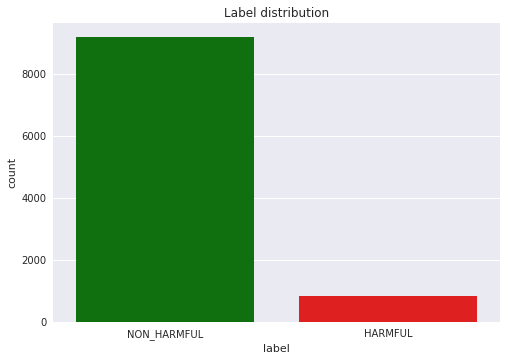

In [17]:
# Customization
hue_colors = {Labels.NON_HARMFUL.value: 'green',
              Labels.HARMFUL.value: 'red'}

plt.xticks(range(2), ['Positive [0]', 'Negative [1]'])
plt.title('Label distribution')

sns.countplot(x='label', data=df, palette=hue_colors)

plt.xticks(range(2), [Labels.NON_HARMFUL.name, Labels.HARMFUL.name])
plt.show()

Unfortunately the labels are not equally distributed. This may be a significant problem and has to be considered in evaluation metrics.

### Length of tweets

In [18]:
tweet_lengths = df.copy()
tweet_lengths['length'] = tweet_lengths['text'].str.len()
tweet_lengths.head()

,text,label,length
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,78
1,@anonymized_account @anonymized_account Brawo ...,0,82
2,"@anonymized_account @anonymized_account Super,...",0,125
3,@anonymized_account @anonymized_account Musi. ...,0,67
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,47


Average and Median tweet length

In [19]:
print(f'Average tweet length: {int(np.mean(tweet_lengths["length"]))}')
print(f'Median tweet length: {int(np.median(tweet_lengths["length"]))}')

Average tweet length: 93
Median tweet length: 91


Average and Median tweet length compared to the max tweet length

In [20]:
print(f'Average tweet length / tweet max length ratio: {round(np.mean(tweet_lengths["length"]) / MAX_TWEET_LENGTH, 3)}')
print(f'Median tweet length / tweet max length ratio: {round(np.median(tweet_lengths["length"]) / MAX_TWEET_LENGTH, 3)}')

Average tweet length / tweet max length ratio: 0.334
Median tweet length / tweet max length ratio: 0.325


In most cases, people only use 30% of the max tweet length

### Does the tweet length correlate with the tweet's sentiment?

Tweet length distribution

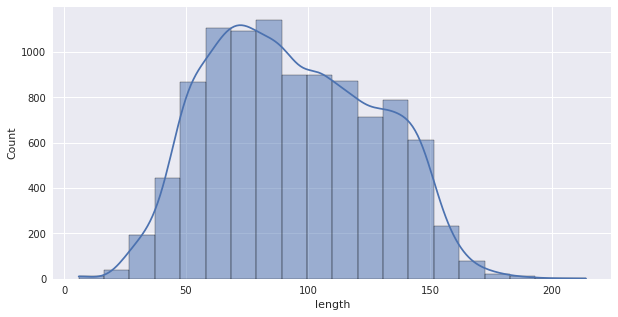

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(x='length', data=tweet_lengths, kde=True, bins=20)
plt.show()

It seems like the tweet length is having a normal (right skewed) distribution, and it is. How does the distribution look like for each class?

### Tweet length distribution by dlass

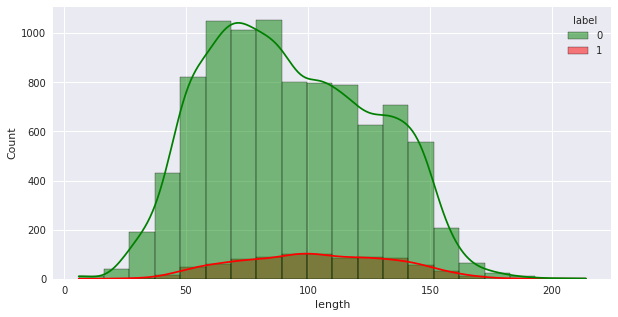

In [22]:
plt.figure(figsize=(10,5))
sns.histplot(x='length', data=tweet_lengths, kde=True, hue='label', bins=20, palette=hue_colors)
plt.show()


The number of classes is not well distributed, let's examine the distribution for each class separately

- Positive sentiment

[]

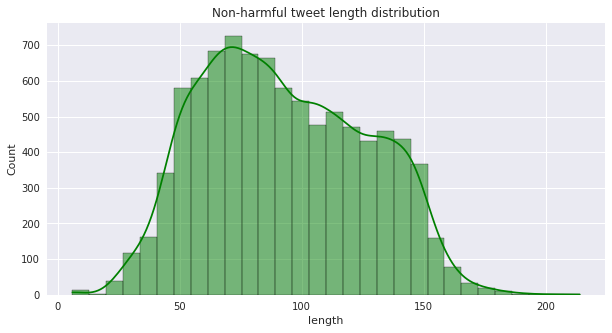

In [23]:
plt.figure(figsize=(10,5))
g = sns.histplot(x='length', data=tweet_lengths[tweet_lengths['label'] == Labels.NON_HARMFUL.value], kde=True, color='green', bins=30)
g.set_title('Non-harmful tweet length distribution')
plt.plot()

Right skewed distribution (positive skewness)

In [24]:
tweet_lengths[tweet_lengths['label'] == Labels.NON_HARMFUL.value]['length'].mode()

0    65
dtype: int64

The most frequent non harmful tweet length (mode - dominanta) is somewhere about 65-80

- Negative sentiment

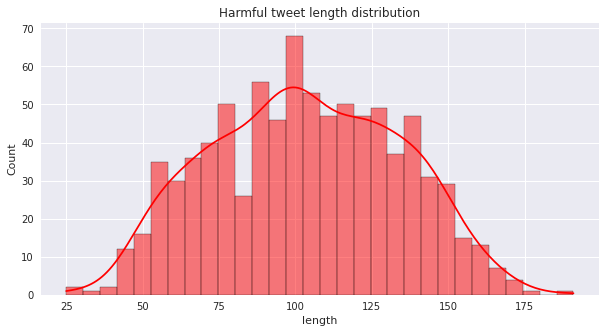

In [25]:
plt.figure(figsize=(10,5))
g = sns.histplot(x='length', data=tweet_lengths[tweet_lengths['label'] == Labels.HARMFUL.value], kde=True, color='red', bins=30)
g.set_title('Harmful tweet length distribution')
plt.show()

Normal distribution

In [26]:
tweet_lengths[tweet_lengths['label'] == Labels.HARMFUL.value]['length'].mode()

0     97
1    103
dtype: int64

The most frequent, harmful tweet length (mode - dominanta) is somewhere about 95 - 105

It looks like that the tweet length may be correlated with the sentiment, as the tweets with negative sentiment are usually longer.

In [27]:
label_median_lengths = tweet_lengths[['label', 'length']].groupby('label').median()
label_median_lengths

,length
label,
0,89
1,103


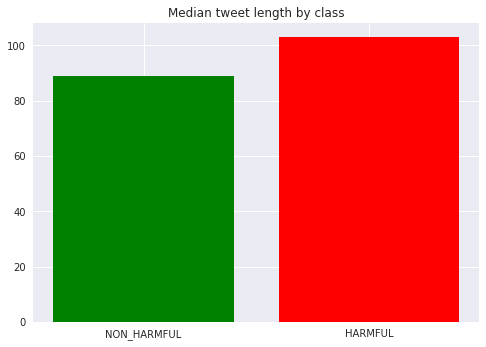

In [28]:
plt.bar(label_median_lengths.index, label_median_lengths.length, color=['g', 'r'])
plt.xticks(range(2), [Labels.NON_HARMFUL.value, Labels.HARMFUL.value])

plt.xticks(range(2), [Labels.NON_HARMFUL.name, Labels.HARMFUL.name])
plt.title('Median tweet length by class')
plt.show()

In most cases a negative tweet is longer.
Adding a `length` column to the training dataset may be a good idea

## Word Counts (Bag-of-Words)

Counting each word occurrences in every tweet 

In [29]:
count_vectorizer = CountVectorizer()

In [30]:
cv_transformed = count_vectorizer.fit_transform(df['text']).toarray()
count_vectorizer.get_feature_names()[1000:1020]

['biedak',
 'biedaku',
 'biedna',
 'biedne',
 'biednego',
 'biedni',
 'biedniejsze',
 'biedniejszych',
 'biedny',
 'biedronce',
 'biedronka',
 'biedronki',
 'biedroń',
 'biedy',
 'biedę',
 'bieg',
 'biega',
 'biegali',
 'biegam',
 'biegania']

In [31]:
df_cv = pd.DataFrame(cv_transformed, columns=count_vectorizer.get_feature_names())
df_cv.head()

,00,01,02s91ipder,03,04,06,0888888888,0jdgav1mow,0q4pyaqhlz,0sxlbtcpgh,...,żądza,żądło,żłobu,лайка,איזה,הנשיא,מצוין,פולני,רעיון,של
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- ### Number of words per tweet

In [32]:
num_words_per_tweet = df_cv.sum(axis=1)
num_words_per_tweet

0        12
1        11
2        13
3         7
4         6
         ..
10036     5
10037    16
10038     8
10039    14
10040     6
Length: 10041, dtype: int64

- Average and Median number of words per tweet 

In [33]:
print(f'Average number of words in a tweet: {int(np.mean(num_words_per_tweet))}')
print(f'Median number of words in a tweet: {int(np.median(num_words_per_tweet))}')

Average number of words in a tweet: 11
Median number of words in a tweet: 11


In [34]:
print(f'Average number of words in a tweet: {int(np.mean(num_words_per_tweet))}')
print(f'Median number of words in a tweet: {int(np.median(num_words_per_tweet))}')

Average number of words in a tweet: 11
Median number of words in a tweet: 11


- Distribution of the number of words per tweet

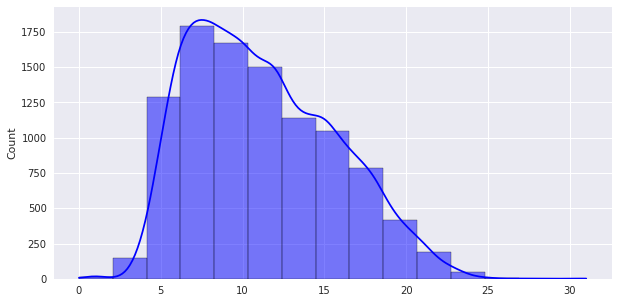

In [35]:
plt.figure(figsize=(10, 5))
sns.histplot(num_words_per_tweet, bins=15, kde=True, color='blue')

plt.show()

Right skewed distribution

- Distribution of the number of words for each class

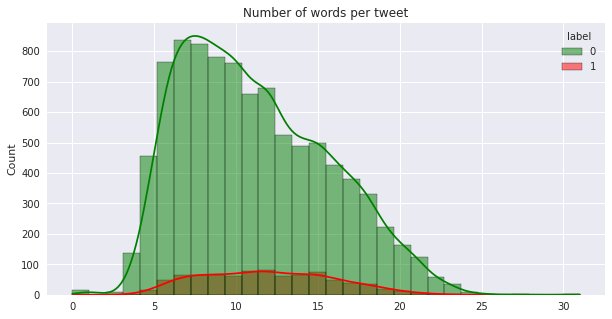

In [36]:
plt.figure(figsize=(10, 5))
g = sns.histplot(x=num_words_per_tweet, bins=30, kde=True, hue=df['label'], palette=hue_colors)
g.set_title('Number of words per tweet')
plt.show()

As previously, the number of classes is not well distributed, let's examine the distribution for each class separately

- #### Non-harmful

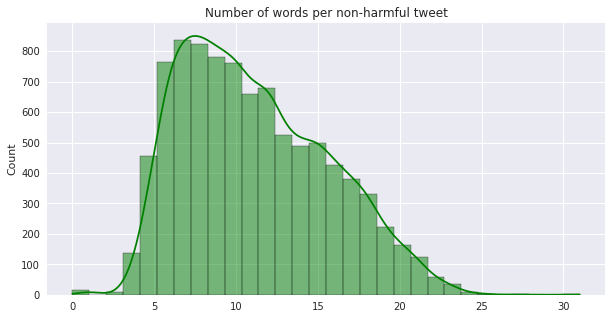

In [37]:
plt.figure(figsize=(10, 5))
g = sns.histplot(x=num_words_per_tweet[df['label'] == Labels.NON_HARMFUL.value], bins=30, kde=True, color='g')
g.set_title('Number of words per non-harmful tweet')
plt.show()

Right skewed distribution

- Calculating the mode

In [38]:
num_words_per_tweet[df['label'] == Labels.NON_HARMFUL.value].mode()

0    7
dtype: int64

Non harmful tweets have in most cases a length of 6-7 words

- #### Harmful

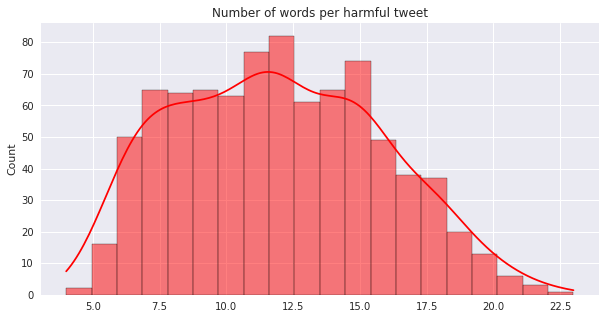

In [39]:
plt.figure(figsize=(10, 5))
g = sns.histplot(x=num_words_per_tweet[df['label'] == Labels.HARMFUL.value], bins=20, kde=True, color='r')
g.set_title('Number of words per harmful tweet')
plt.show()

Seems to be a normal distribution

- Mode

In [40]:
num_words_per_tweet[df['label'] == Labels.HARMFUL.value].mode()

0    12
dtype: int64

Harmful tweets have in most cases a length of 11-12 words

The analysis above shows us, that adding a column with the number of words in a tweet could be a good idea, as the number of words differs for each class

    Of course, in the calculations above we did include the all numbers and symbols, however we are exploring the raw dataset for now. Further evaluation should be performed after removing numbers, emoji's and other symbols incorrecly recognized as words 

- #### Average and Median word length

In [41]:
word_lengths = {word: len(word) for word in df_cv.columns}

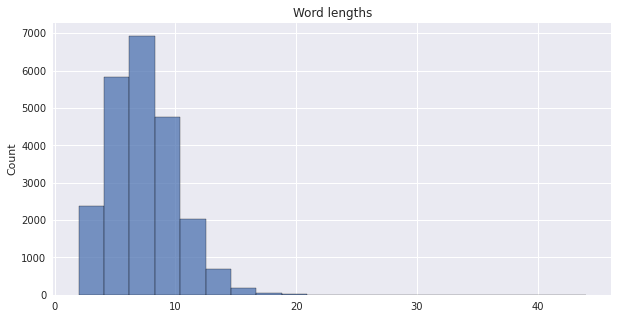

In [42]:
plt.figure(figsize=(10, 5))
g = sns.histplot(x=word_lengths.values(), bins=20)
g.set_title('Word lengths')
plt.show()

- ## Most frequent words

In [43]:
word_occurrences = df_cv.sum(axis=0)
word_occurrences

00            25
01             5
02s91ipder     1
03             1
04             1
              ..
הנשיא          2
מצוין          2
פולני          2
רעיון          2
של             2
Length: 22872, dtype: int64

In [44]:
word_occurrences.describe()

count    22872.000000
mean         4.943555
std        100.021885
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      13762.000000
dtype: float64

In [45]:
sorted_word_occurrences = word_occurrences.sort_values(ascending=False)
sorted_word_occurrences

anonymized_account    13762
nie                    3131
to                     2991
na                     2093
się                    1803
                      ...  
niszczysz                 1
tottenham                 1
towar                     1
nistety                   1
patosem                   1
Length: 22872, dtype: int64

In [46]:
num_words = len(word_occurrences)
num_words

22872

In [47]:
np.sum(word_occurrences > 1)

9427

In [48]:
np.sum(word_occurrences > 1) / num_words

0.41216334382651276

60% of all words occur only once, lets examine the distribution

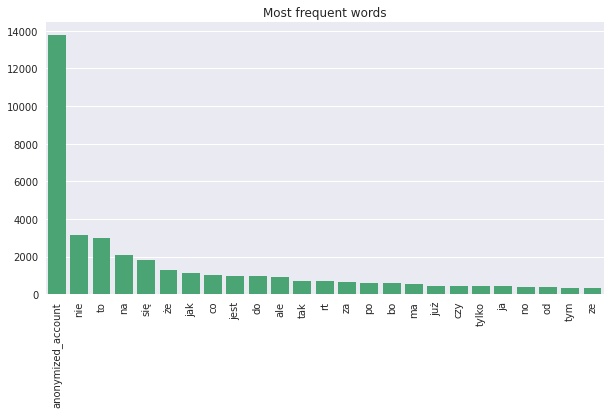

In [49]:
plt.figure(figsize=(10, 5))
g = sns.barplot(x=sorted_word_occurrences[:25].index, y=sorted_word_occurrences[:25].values, color='mediumseagreen')
g.set_title('Most frequent words')
plt.xticks(rotation=90)
plt.show()

Exponential distribution (Long tail)

As we can see, most of these are stop words, let's remove them and get the most frequent ones.

### Temporarily removing Polish stopwords, to get the most frequent words of the dataset

- #### Removing new line chars

In [50]:
def filter_newline(text):
    return text.replace('\\n', ' ').replace('\\r', ' ')

In [51]:
filtered_df = df['text'].str.lower().apply(filter_newline)
filtered_df.head()

0    dla mnie faworytem do tytułu będzie cracovia. ...
1    @anonymized_account @anonymized_account brawo ...
2    @anonymized_account @anonymized_account super,...
3    @anonymized_account @anonymized_account musi. ...
4      odrzut natychmiastowy, kwaśna mina, mam problem
Name: text, dtype: object

- #### Removing links

In [52]:
url_pattern = r'((www.[^s]+)|(https?://[^s]+))'
# url_pattern = r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'

In [53]:
def filter_url(text, url_pattern):
    return re.sub(url_pattern, ' ', text)

In [54]:
filtered_df = filtered_df.apply(lambda x: filter_url(x, url_pattern))
filtered_df.head()

0    dla mnie faworytem do tytułu będzie cracovia. ...
1    @anonymized_account @anonymized_account brawo ...
2    @anonymized_account @anonymized_account super,...
3    @anonymized_account @anonymized_account musi. ...
4      odrzut natychmiastowy, kwaśna mina, mam problem
Name: text, dtype: object

- #### Removing numbers

In [55]:
def filter_numbers(text):
    number_pattern = r'[0-9]+'
    return re.sub(number_pattern, '', text)

In [56]:
filtered_df = filtered_df.apply(filter_numbers)
filtered_df.head()

0    dla mnie faworytem do tytułu będzie cracovia. ...
1    @anonymized_account @anonymized_account brawo ...
2    @anonymized_account @anonymized_account super,...
3    @anonymized_account @anonymized_account musi. ...
4      odrzut natychmiastowy, kwaśna mina, mam problem
Name: text, dtype: object

- #### Filter non ASCII characters

In [57]:
def filter_ascii(text):
    return re.sub(r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]', '', text) 

In [58]:
filtered_df = filtered_df.apply(filter_ascii)
filtered_df.head()

0    dla mnie faworytem do tytułu będzie cracovia. ...
1    @anonymized_account @anonymized_account brawo ...
2    @anonymized_account @anonymized_account super,...
3    @anonymized_account @anonymized_account musi. ...
4      odrzut natychmiastowy, kwaśna mina, mam problem
Name: text, dtype: object

- #### Removing punctuations

In [60]:
# def filter_punctuations(words, punctuations):
#     return list(filter(lambda x: x not in punctuations, words))

def filter_punctuations(text, punctuations):
    translator = str.maketrans('', '', punctuations)
    return text.translate(translator)

In [61]:
filtered_df = filtered_df.apply(lambda x: filter_punctuations(x, string.punctuation))
filtered_df

0        dla mnie faworytem do tytułu będzie cracovia z...
1        anonymizedaccount anonymizedaccount brawo ty d...
2        anonymizedaccount anonymizedaccount super pols...
3        anonymizedaccount anonymizedaccount musi innej...
4            odrzut natychmiastowy kwaśna mina mam problem
                               ...                        
10036         anonymizedaccount ty zagrasz nie wiedziałem 
10037    anonymizedaccount anonymizedaccount a var nie ...
10038    anonymizedaccount anonymizedaccount szanowany ...
10039    anonymizedaccount anonymizedaccount anonymized...
10040    anonymizedaccount a wróżbita maciej mówi że zr...
Name: text, Length: 10041, dtype: object

- #### Lemmatization

In [62]:
import spacy

In [63]:
lemma_model = spacy.load('pl_core_news_sm')

In [64]:
def lemmatize_sentence(lemma_model, text):
    doc = lemma_model(text)
    return ' '.join([token.lemma_ for token in doc])

In [65]:
df_lemmatized = filtered_df.apply(lambda x: lemmatize_sentence(lemma_model, x))
df_lemmatized.head()

0    dla ja faworyt do tytuł być cracovia zobaczyć ...
1    anonymizedaccount anonymizedaccount brawo ty d...
2    anonymizedaccount anonymizedaccount super pols...
3    anonymizedaccount anonymizedaccount musić inny...
4       odrzut natychmiastowy kwaśna mina mieć problem
Name: text, dtype: object

- #### Tokenizing words

In [66]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer #, word_tokenize

In [67]:
tweet_tokenizer = TweetTokenizer()

In [68]:
tokenized_df = df_lemmatized.apply(tweet_tokenizer.tokenize)
tokenized_df

0        [dla, ja, faworyt, do, tytuł, być, cracovia, z...
1        [anonymizedaccount, anonymizedaccount, brawo, ...
2        [anonymizedaccount, anonymizedaccount, super, ...
3        [anonymizedaccount, anonymizedaccount, musić, ...
4        [odrzut, natychmiastowy, kwaśna, mina, mieć, p...
                               ...                        
10036       [anonymizedaccount, ty, zagrać, nie, wiedzieć]
10037    [anonymizedaccount, anonymizedaccount, a, var,...
10038    [anonymizedaccount, anonymizedaccount, szanowa...
10039    [anonymizedaccount, anonymizedaccount, anonymi...
10040    [anonymizedaccount, a, wróżbit, maciej, mówić,...
Name: text, Length: 10041, dtype: object

- #### Removing stop words

Loading polish stop words

In [69]:
polish_stopwords = set(stopwords.words('polish'))
print(stopwords.words('polish'))

['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ', 'ani', 'az', 'aż', 'bardziej', 'bardzo', 'beda', 'bedzie', 'bez', 'deda', 'będą', 'bede', 'będę', 'będzie', 'bo', 'bowiem', 'by', 'byc', 'być', 'byl', 'byla', 'byli', 'bylo', 'byly', 'był', 'była', 'było', 'były', 'bynajmniej', 'cala', 'cali', 'caly', 'cała', 'cały', 'ci', 'cie', 'ciebie', 'cię', 'co', 'cokolwiek', 'cos', 'coś', 'czasami', 'czasem', 'czemu', 'czy', 'czyli', 'daleko', 'dla', 'dlaczego', 'dlatego', 'do', 'dobrze', 'dokad', 'dokąd', 'dosc', 'dość', 'duzo', 'dużo', 'dwa', 'dwaj', 'dwie', 'dwoje', 'dzis', 'dzisiaj', 'dziś', 'gdy', 'gdyby', 'gdyz', 'gdyż', 'gdzie', 'gdziekolwiek', 'gdzies', 'gdzieś', 'go', 'i', 'ich', 'ile', 'im', 'inna', 'inne', 'inny', 'innych', 'iz', 'iż', 'ja', 'jak', 'jakas', 'jakaś', 'jakby', 'jaki', 'jakichs', 'jakichś', 'jakie', 'jakis', 'jakiś', 'jakiz', 'jakiż', 'jakkolwiek', 'jako', 'jakos', 'jakoś', 'ją', 'je', 'jeden', 'jedna', 'jednak', 'jednakze', 'jednakże', 'jedno'

In [70]:
def filter_stopwords(words, stop_words_list):
    return [word for word in words if word.lower() not in stop_words_list]

Filtering polish stop words

In [71]:
filtered_df_2 = tokenized_df.apply(lambda x: filter_stopwords(x, polish_stopwords))
filtered_df_2

0        [faworyt, tytuł, cracovia, zobaczyć, typ, spra...
1        [anonymizedaccount, anonymizedaccount, brawo, ...
2        [anonymizedaccount, anonymizedaccount, super, ...
3        [anonymizedaccount, anonymizedaccount, musić, ...
4        [odrzut, natychmiastowy, kwaśna, mina, mieć, p...
                               ...                        
10036                [anonymizedaccount, zagrać, wiedzieć]
10037    [anonymizedaccount, anonymizedaccount, var, mi...
10038    [anonymizedaccount, anonymizedaccount, szanowa...
10039    [anonymizedaccount, anonymizedaccount, anonymi...
10040    [anonymizedaccount, wróżbit, maciej, mówić, zr...
Name: text, Length: 10041, dtype: object

- #### Filter taggings

In [72]:
def filter_word(words, forbidden_words):
    return [word for word in words if word not in forbidden_words]


In [73]:
filtered_df_2 = filtered_df_2.apply(lambda x: filter_word(x, {'anonymizedaccount', 'rt'}))
filtered_df_2

0        [faworyt, tytuł, cracovia, zobaczyć, typ, spra...
1                  [brawo, daria, kibic, mieć, dobry, zły]
2        [super, polski, premiera, składać, kwiat, grób...
3                                     [musić, droga, mieć]
4        [odrzut, natychmiastowy, kwaśna, mina, mieć, p...
                               ...                        
10036                                   [zagrać, wiedzieć]
10037    [var, mieć, poprawić, jakość, sędziowania, efe...
10038                [szanowany, kolega, ładnie, pożegnać]
10039    [mieć, bić, zwyciezca, liga, wojewódzki, grać,...
10040                  [wróżbit, maciej, mówić, zrozumieć]
Name: text, Length: 10041, dtype: object

- #### Filter duplicate characters

In [ ]:
# def clean_repeting_char(text):
    # return re.sub(r'(.)1+', r'1', text)
    # return re.sub(r'(.)\1+', r'.', text)

Back to text

In [74]:
def arr_to_string(arr):
    return ' '.join(word for word in arr)

In [75]:
df_clean = filtered_df_2.apply(arr_to_string)
df_clean

0            faworyt tytuł cracovia zobaczyć typ sprawdzić
1                         brawo daria kibic mieć dobry zły
2        super polski premiera składać kwiat grób kolab...
3                                         musić droga mieć
4           odrzut natychmiastowy kwaśna mina mieć problem
                               ...                        
10036                                      zagrać wiedzieć
10037    var mieć poprawić jakość sędziowania efekt koń...
10038                     szanowany kolega ładnie pożegnać
10039     mieć bić zwyciezca liga wojewódzki grać barazach
10040                       wróżbit maciej mówić zrozumieć
Name: text, Length: 10041, dtype: object

### Most frequent words after filtering

In [76]:
count_vectorizer_2 = CountVectorizer()

In [77]:
cv_transformed_2 = count_vectorizer_2.fit_transform(df_clean).toarray()
count_vectorizer_2.get_feature_names()[3000:3020]

['griezmann',
 'griezmanna',
 'gro',
 'grobowiec',
 'grodzickiego',
 'gromadzenia',
 'grosicki',
 'grosickiego',
 'grosickim',
 'grosik',
 'grosikkownaś',
 'grosz',
 'grosze',
 'groszek',
 'groteskowy',
 'groza',
 'groziles',
 'grozić',
 'grozićprofcentkiewiczowi',
 'groźny']

In [78]:
df_cv_2 = pd.DataFrame(cv_transformed_2, columns=count_vectorizer_2.get_feature_names())
df_cv_2.head()

,aa,aaaa,aaaaa,aaaaaa,aaaaaaaaaaaaaaa,aahhhh,abarcji,abidal,abnegacja,abonament,...,żółto,żółty,żółwik,żółć,żądamy,żądanie,żądać,żądza,żądło,żłób
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
word_occurrences = df_cv_2.sum(axis=0)
sorted_word_occurrences = word_occurrences.sort_values(ascending=False)
sorted_word_occurrences.head(20)

mieć        1386
móc          470
wiedzieć     381
chcieć       320
dobry        288
mecz         288
chyba        257
rok          251
grać         232
mówić        210
czas         196
raz          180
robić        179
widzieć      178
zrobić       158
dać          156
polski       148
chodzić      148
xd           147
musić        146
dtype: int64

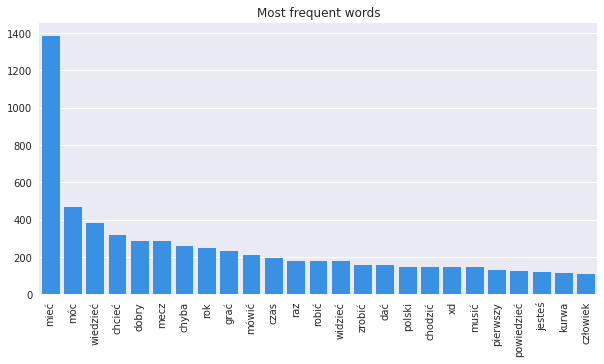

In [92]:
plt.figure(figsize=(10, 5))
g = sns.barplot(x=sorted_word_occurrences[:25].index, y=sorted_word_occurrences[:25].values, color='dodgerblue')
g.set_title('Most frequent words')
plt.xticks(rotation=90)
plt.show()

- #### Most frequent words in non harmful tweets

In [88]:
word_occurrences_nh = df_cv_2[df['label'] == Labels.NON_HARMFUL.value].sum(axis=0)
sorted_word_occurrences_nh = word_occurrences_nh.sort_values(ascending=False)
sorted_word_occurrences_nh.head(20)

mieć        1299
móc          429
wiedzieć     342
chcieć       307
mecz         285
dobry        279
chyba        242
rok          239
grać         229
mówić        192
czas         182
raz          174
robić        166
widzieć      160
dać          144
xd           144
chodzić      144
zrobić       142
musić        137
polski       125
dtype: int64

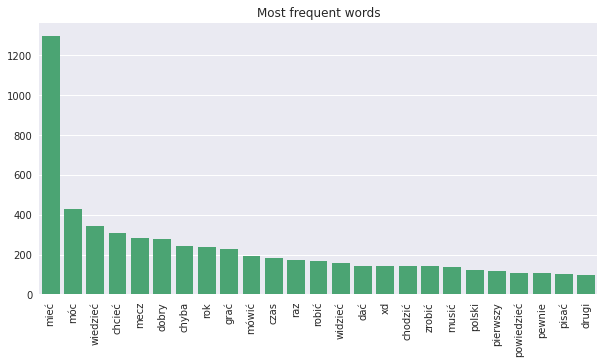

In [90]:
plt.figure(figsize=(10, 5))
g = sns.barplot(x=sorted_word_occurrences_nh[:25].index, y=sorted_word_occurrences_nh[:25].values, color='mediumseagreen')
g.set_title('Most frequent words')
plt.xticks(rotation=90)
plt.show()

- #### Most frequent words in harmful tweets

In [89]:
word_occurrences_h = df_cv_2[df['label'] == Labels.HARMFUL.value].sum(axis=0)
sorted_word_occurrences_h = word_occurrences_h.sort_values(ascending=False)
sorted_word_occurrences_h.head(20)

mieć          87
jesteś        49
móc           41
wiedzieć      39
kurwa         30
debil         27
dupa          25
polski        23
pisowski      22
pajac         20
mózg          19
powiedzieć    18
widzieć       18
chuj          18
mówić         18
człowiek      17
pis           17
stary         16
zrobić        16
kobieta       16
dtype: int64

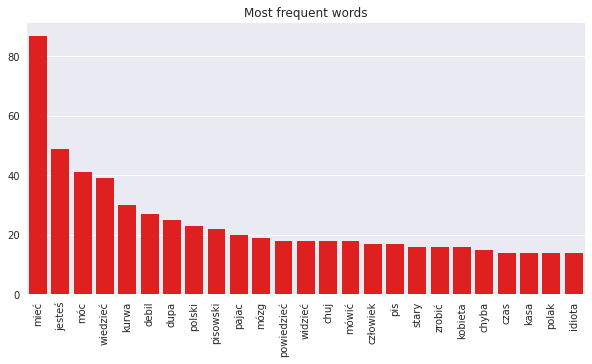

In [93]:
plt.figure(figsize=(10, 5))
g = sns.barplot(x=sorted_word_occurrences_h[:25].index, y=sorted_word_occurrences_h[:25].values, color='red')
g.set_title('Most frequent words')
plt.xticks(rotation=90)
plt.show()

As we can see, the words used differ significantly.
The harmful tweets contain much more curses.

### WordCloud with most frequent words

The `@anonymized_account` text is the most frequent word in the dataset.
Let's check if it is present in every tweet, and maybe delete it

In [ ]:
df_lower = df.copy()
df_lower['text'] = df['text'].str.lower()
df_lower.head()

,text,label
0,dla mnie faworytem do tytułu będzie cracovia. ...,0
1,@anonymized_account @anonymized_account brawo ...,0
2,"@anonymized_account @anonymized_account super,...",0
3,@anonymized_account @anonymized_account musi. ...,0
4,"odrzut natychmiastowy, kwaśna mina, mam problem",0


In [ ]:
start_anon_acc_pattern = r'^@anonymized_account'
anon_acc_pattern = r'@anonymized_account'

In [ ]:
df_lower['text'].str.count(anon_acc_pattern).sum()

13762

In [ ]:
df_lower['text'].str.count(anon_acc_pattern).sum() / num_words

0.6016963973417279

This shows us, that 60% of all words are `@anonymized_account` - tagged accounts

In [ ]:
df_lower['text'].str.match(start_anon_acc_pattern).sum()

7565

Adding a Reply (`Reply`) boolean column

In [ ]:
# if startswith.(@anonymized_account) ...

# UWAGA, może być też po RT więc wtedy 'RT @anonymized_account'

Mention/Reference - if the @anonymized_account is in the middle, or is not followed by another from the start?

In [ ]:
def check_if_reference(tweet_text):
    pass

Adding a RT (Re-Tweets) column?

According to Twitter FAQ, this is not an official feature and cannot be trusted

```
Sometimes people type "RT" at the beginning of a Tweet to indicate that they are re-posting someone else's content. This isn't an official Twitter command or feature, but signifies that they are quoting another person's Tweet.
```

### Most common hash tags #

In [ ]:
# https://towardsdatascience.com/visualization-of-information-from-raw-twitter-data-part-1-99181ad19c

Analysis:
- https://towardsdatascience.com/sentiment-analysis-concept-analysis-and-applications-6c94d6f58c17
- https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28
- https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
- https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

- Perform simple analysis:
    - [DONE] Word count by class
    - [DONE] Length of tweets
    - [DONE] Average tweet length by class
    - [IN PROGRESS] Most frequent words
    - Most frequent words by class
- Remove emoji's? Or maybe tokenize them
    - https://github.com/huggingface/transformers/issues/7648
    - https://stackoverflow.com/questions/57679668/tokenizing-emojis-contiguous-to-words

- Check if replying and mentioning other account by `@anonymized_account`, is correlated with the labels


Preprocessing:
- Lower the text? (not always as capital text is 'shouting') - check if more uppercase means cyberbullying
- Remove duplicates (181 i 182 - duplikaty)
- Create a pipeline!!!